In [23]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [26]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [29]:
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [30]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


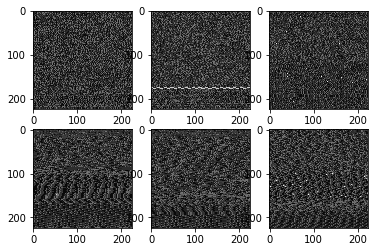

In [5]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [31]:
# feature extraction
IMG_SHAPE = (224,224,3) # Input image shape
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,           
                         pooling ='avg',                                                       
                         weights='imagenet')

In [32]:
model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1024, activation='relu')])
                                                                                    # Applying keras sequential layer to 
                                                                                    # base model with relu activation to 
                                                                                    # extract only features from images 
                                                                                    # without making prediction
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
Total params: 3,569,728
Trainable params: 3,535,616
Non-trainable params: 34,112
_________________________________________________________________


In [33]:
model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1024, activation='relu')])
                                                                                    # Applying keras sequential layer to 
                                                                                    # base model with relu activation to 
                                                                                    # extract only features from images 
                                                                                    # without making prediction
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
Total params: 3,569,728
Trainable params: 3,535,616
Non-trainable params: 34,112
_________________________________________________________________


In [34]:
data_labels = set(categories)
image_path = list(paths.list_images(base_path))
images = []                                                   # appending trainable features from MobileNetV1
labels = []                                                   # appending trainable lables from MobileNetV1
img_width = 224                                               # Image size
img_height = 224

In [10]:
for img in image_path:
    label = img.split(os.path.sep)[-2]
    image = cv2.imread(img)                                    # Reading images using CV2
    rezise_image = cv2.resize(image, (img_width, img_height))  # Resizing Images
    x = np.expand_dims(rezise_image, axis=0)                   # Converting x into 1-D array
    x = preprocess_input(x)
    features = model.predict(x)                                # Predicting features of X
    images.append(features)                                    # Appending features to train_features
    labels.append(label)

In [11]:
x = np.concatenate(images, axis=0)
y = np.array(labels)

In [12]:
# np.save('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV2_X.npy', x)
# np.save('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV2_y.npy', y)

In [35]:
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV2_feat_bytes_microsoft_1024.npy')
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV2_feat_asm_microsoft_1024.npy')

In [36]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)
X =  np.array(X)
X.shape

(10868, 2048)

In [37]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [39]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [40]:
rf =  RandomForestClassifier(n_estimators= 100,n_jobs= 2)

In [44]:
%%time
rf.fit(X_train,y_train)

CPU times: user 30.2 s, sys: 123 ms, total: 30.3 s
Wall time: 15.5 s


RandomForestClassifier(n_jobs=2)

In [45]:
print("Testing Accuracy:", round((rf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 94.04


In [46]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 178 ms, sys: 7.95 ms, total: 186 ms
Wall time: 111 ms


In [47]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

94 94 94
CPU times: user 6.53 ms, sys: 239 µs, total: 6.77 ms
Wall time: 5.9 ms


In [48]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       224
         1.0       0.85      1.00      0.92        69
         2.0       0.99      1.00      1.00       619
         3.0       0.96      0.88      0.92       553
         4.0       0.89      0.96      0.93       226
         5.0       0.94      0.92      0.93       338
         6.0       0.00      0.00      0.00         0
         7.0       0.85      0.91      0.88       145
         8.0       0.93      0.95      0.94       109

    accuracy                           0.94      2283
   macro avg       0.82      0.84      0.83      2283
weighted avg       0.94      0.94      0.94      2283



In [49]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [50]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

CPU times: user 99 µs, sys: 9 µs, total: 108 µs
Wall time: 124 µs


In [51]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 21min 23s, sys: 2min 30s, total: 23min 54s
Wall time: 4h 43min 3s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=2),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [52]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [54]:
%%time
print("Accuracy on testing set: {:.4f}".format(grid_search.score(X_test, y_test)))

Accuracy on testing set: 0.9409
CPU times: user 306 ms, sys: 32.6 ms, total: 339 ms
Wall time: 223 ms


In [55]:
y_pred = grid_search.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       219
         1.0       1.00      0.84      0.91        81
         2.0       1.00      0.99      1.00       624
         3.0       0.88      0.96      0.92       507
         4.0       0.98      0.89      0.93       245
         5.0       0.90      0.93      0.92       332
         6.0       0.00      0.00      0.00         7
         7.0       0.92      0.85      0.88       156
         8.0       0.96      0.93      0.95       112

    accuracy                           0.94      2283
   macro avg       0.84      0.82      0.83      2283
weighted avg       0.94      0.94      0.94      2283



In [56]:
list_fams = sorted(label_dict.keys())

In [57]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V2_RandomForest_st.csv')

Plotting the confusion matrix


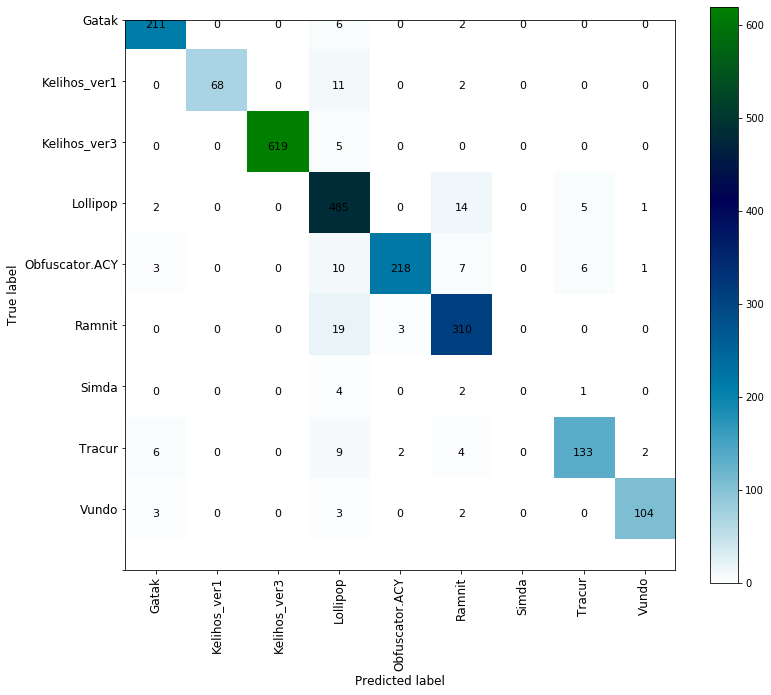

In [58]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V2_RandomForest_st.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V2_RandomForest_st.png', bbox_inches='tight')

plt.show()

In [35]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [36]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [37]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [38]:
FP, FN, TP, TN

(array([ 55,  25, 162, 333,  33, 178,   1,  24,   5]),
 array([197,  66,  51,  98,  66,  82,   9, 146, 101]),
 array([ 31,  16, 585, 411, 180, 234,   0,   6,   4]),
 array([2000, 2176, 1485, 1441, 2004, 1789, 2273, 2107, 2173]))

In [39]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.08966773, 0.029438  , 0.03320312, 0.06367771, 0.03188406,
       0.04382683, 0.00394391, 0.06480249, 0.04441513])

In [40]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [41]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.135965,0.973236,0.026764,0.864035,0.639535,0.089668
Kelihos_ver1,0.195122,0.988642,0.011358,0.804878,0.609756,0.029438
Kelihos_ver3,0.919811,0.901639,0.098361,0.080189,0.216867,0.033203
Lollipop,0.807466,0.812289,0.187711,0.192534,0.447581,0.063678
Obfuscator.ACY,0.731707,0.983800,0.016200,0.268293,0.154930,0.031884
Ramnit,0.740506,0.909507,0.090493,0.259494,0.432039,0.043827
Simda,0.000000,0.999560,0.000440,1.000000,1.000000,0.003944
Tracur,0.039474,0.988738,0.011262,0.960526,0.800000,0.064802
Vundo,0.038095,0.997704,0.002296,0.961905,0.555556,0.044415


In [42]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 40.0905
Average of true_negative_rate --> 95.0568
Average of false_positive_rate --> 4.9432
Average of false_negative_rate --> 59.9095
Average of false_discovery_rate --> 53.9585
Average of false_omission_rate --> 4.4984


In [43]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.56


In [44]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.6425755584756899
micro_recall : 0.6425755584756899
micro_f1_score : 0.6425755584756899


In [45]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.46041521507838723
macro_recall : 0.4009051524009223
macro_f1_score : 0.39143419192511075


In [46]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [47]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [48]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

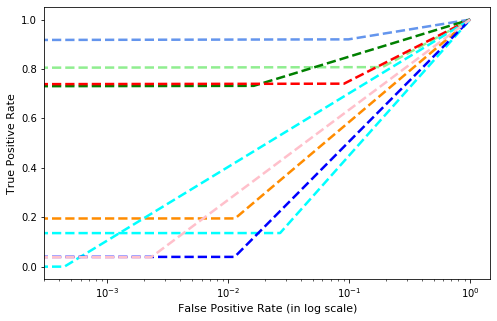

In [49]:
3#pute macro-average ROC curve an_std ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V2_RandomForest_st.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V2_RandomForest_st.png", bbox_inches='tight')

plt.show()